# Forecasting
t<sub>0</sub> corresponds to the time at which the forecast is made (12:00 CET) for EPEX SPOT day-ahead auction.<br>

In [1]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from collections import defaultdict

from utils import tools, preprocessing, models, eval, plotting, hpo

2025-09-05 20:01:21.567362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757095281.589043  293975 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757095281.596066  293975 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757095281.614312  293975 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757095281.614334  293975 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757095281.614336  293975 computation_placer.cc:177] computation placer alr

In [2]:
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 1.4.2
Numpy version: 1.26.4
Tensorflow version: 2.19.0


In [3]:
config = tools.load_config('configs/config_wind.yaml')
tools.initialize_gpu(7)

In [4]:
# paths
data = 'synth_wind/client_a'
key = 'synth_00161.csv'
target_col = 'power_t1'

# model params
model_name = 'tcn-gru'
output_dim = 1 # in hours
epochs = 20
batch_size = 32
make_callbacks = False
strategy = 'fedavg'
n_cnn_layers = 5
n_rnn_layers = 1
n_layers = 2
dropout = 0.1

# data params
freq = '1h'
lookback = 24 # in hours
horizon = 24 # in hours
# data split params
t_0 = 0 # epex spot auction time (12:00 CET)
scale_y = False
lag_in_col = False

# more params
evaluate_on_all_test_data = True
study_name = None#f'fl_a-{strategy}_d-{data}_m-{model_name}_out-{output_dim}_freq-{freq}'

In [5]:
# config related
config['data']['freq'] = freq
config['model']['name'] = model_name
config['model']['output_dim'] = output_dim
config['model']['lookback'] = lookback
config['model']['horizon'] = horizon
config = tools.handle_freq(config=config)
freq = config['data']['freq']
output_dim = config['model']['output_dim']
config['model']['lookback'] = lookback
config['model']['horizon'] = horizon

In [6]:
# read data

known, observed, static = preprocessing.get_features(dataset_name=data)
rel_features = known + observed
dfs = preprocessing.get_data(dataset_name=data,
                             config=config,
                             data_dir='data',
                             freq=freq,
                             rel_features=rel_features)
df = dfs[key]

In [10]:
df

,wind_speed_nwp,temperature_nwp,pressure_nwp,relhum_nwp,power,forecasttime
timestamp,,,,,,
2023-07-24 06:00:00+00:00,4.432568,290.967652,98363.761591,0.773548,0.009711,0.0
2023-07-24 07:00:00+00:00,2.316333,291.147693,98422.678426,0.783110,0.007401,1.0
2023-07-24 08:00:00+00:00,4.500451,291.536756,98433.876302,0.788478,0.027779,2.0
2023-07-24 09:00:00+00:00,6.872577,292.694529,98435.666171,0.741746,0.131711,3.0
2023-07-24 09:00:00+00:00,5.475161,293.849634,98355.634794,0.713254,0.131711,0.0
...,...,...,...,...,...,...
2025-05-12 12:00:00+00:00,5.144326,292.149123,99164.807360,0.000000,NaN,48.0
2025-05-12 12:00:00+00:00,5.289590,292.003745,99081.120510,0.000000,NaN,45.0
2025-05-12 13:00:00+00:00,4.726705,292.506703,99057.140672,0.000000,NaN,46.0


In [ ]:
test_start = None #pd.Timestamp(config['data']['test_start'])
prepared_data, df = preprocessing.pipeline(data=df,
                                           config=config,
                                           known_cols=known,
                                           observed_cols=observed,
                                           static_cols=static,
                                           test_start=test_start,
                                           target_col=target_col)
X_train, y_train = prepared_data['X_train'], prepared_data['y_train'],
X_test, y_test = prepared_data['X_test'], prepared_data['y_test']
index_train = prepared_data['index_train']
index_test = prepared_data['index_test']
scaler_y = prepared_data['scalers']['y']
#print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [440]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2024-01-01 00:00:00+00:00 to 2024-12-31 23:00:00+00:00
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   wind_speed_nwp            8784 non-null   float64
 1   temperature_2m            8784 non-null   float64
 2   density                   8784 non-null   float64
 3   relative_humidity         8784 non-null   float64
 4   std_v_wind                8784 non-null   float64
 5   pressure                  8784 non-null   float64
 6   wind_direction            8784 non-null   float64
 7   w_vert                    8784 non-null   float64
 8   saturated_vapor_pressure  8784 non-null   float64
 9   wind_speed                8784 non-null   float64
dtypes: float64(10)
memory usage: 1012.9 KB


In [441]:
config['model']['fl'] = False
study = hpo.load_study(config['hpo']['studies_path'], study_name)
hyperparameters = hpo.get_hyperparameters(config=config, study=study)
hyperparameters['epochs'] = epochs#config['model']['epochs']
hyperparameters['batch_size'] = batch_size#config['model']['epochs']
if 'dropout' in hyperparameters:
    hyperparameters['dropout'] = dropout
if 'n_cnn_layers' in hyperparameters:
    hyperparameters['n_cnn_layers'] = n_cnn_layers
if 'n_rnn_layers' in hyperparameters:
    hyperparameters['n_rnn_layers'] = n_rnn_layers
if 'n_layers' in hyperparameters:
    hyperparameters['n_layers'] = n_layers

config['model']['name'] = model_name

config['model']['feature_dim'] = tools.get_feature_dim(X_train)
model = models.get_model(config=config,
                         hyperparameters=hyperparameters)

In [442]:
hyperparameters

{'shuffle': False,
 'batch_size': 32,
 'epochs': 20,
 'lr': 0.001,
 'filters': 64,
 'kernel_size': 3,
 'n_cnn_layers': 5,
 'increase_filters': False,
 'dropout': 0.1,
 'units': 64,
 'n_rnn_layers': 1}

In [443]:
#model.summary()

In [444]:
if make_callbacks:
    callbacks = [keras.callbacks.ModelCheckpoint('models/best.keras', save_best_only=True)]

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = hyperparameters['batch_size'],
    epochs = hyperparameters['epochs'],
    verbose = 'auto',
    callbacks = callbacks if make_callbacks else None,
    validation_data=(X_test, y_test),
    shuffle = hyperparameters['shuffle']
)
if make_callbacks:
    model = keras.models.load_model('models/best.keras')
best_epoch = np.argmin(history.history['val_loss']) + 1

Epoch 1/20


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 34.7177 - mae: 4.5357 - rmse: 5.6235 - val_loss: 3.7420 - val_mae: 1.5322 - val_rmse: 1.9344
Epoch 2/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3.2225 - mae: 1.3878 - rmse: 1.7777 - val_loss: 2.6514 - val_mae: 1.2529 - val_rmse: 1.6283
Epoch 3/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.4253 - mae: 1.2127 - rmse: 1.5492 - val_loss: 2.7342 - val_mae: 1.2650 - val_rmse: 1.6536
Epoch 4/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.1378 - mae: 1.1473 - rmse: 1.4563 - val_loss: 2.8184 - val_mae: 1.2921 - val_rmse: 1.6788
Epoch 5/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.9577 - mae: 1.1017 - rmse: 1.3948 - val_loss: 3.0228 - val_mae: 1.3511 - val_rmse: 1.7386
Epoch 6/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.8897 - mae: 1.0811 - rmse: 1.3703 - val_loss: 3.1276 - val_mae: 1.3810 - val_rmse: 1.7685
Epoch 7/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.8470 - mae: 1.0711 - rmse: 1.

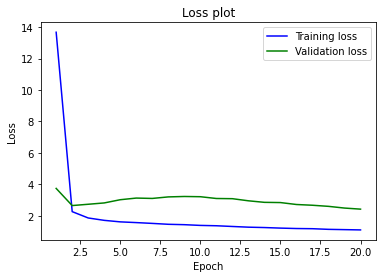

In [445]:
plotting.plot_training(history=history,
                       validation=True,
                       save_name=None)

In [446]:
y_true, y_pred = tools.get_y(X_test=X_test,
                             y_test=y_test,
                             scaler_y=scaler_y,
                             model=model)
df_pred = tools.y_to_df(y=y_pred,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)
df_true = tools.y_to_df(y=y_true,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)

y_pers = eval.persistence(y=df[target_col],
                    horizon=horizon,
                    from_date=str(index_test[0].date()))
y_pers = preprocessing.make_windows(data=y_pers,
                                    seq_len=y_pred.shape[-1])
df_pers = tools.y_to_df(y=y_pers,
                    output_dim=output_dim,
                    horizon=horizon,
                    index_test=index_test,
                    t_0=None if evaluate_on_all_test_data else t_0)

pers = {}
pers['Persistence'] = df_pers

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [447]:
results = eval.evaluate_models(pred=df_pred,
                               true=df_true,
                               persistence=pers,
                               main_model_name=model_name)

In [448]:
results

,R^2,RMSE,MAE,Skill
Models,,,,
cnn-lstm,0.639260,1.553398,1.226070,0.498754
Persistence,-0.435799,3.099076,2.493534,0.000000


R^2: -0.17285144163756305
RMSE: 1.7581351256381952
MAE: 1.4593078182803259


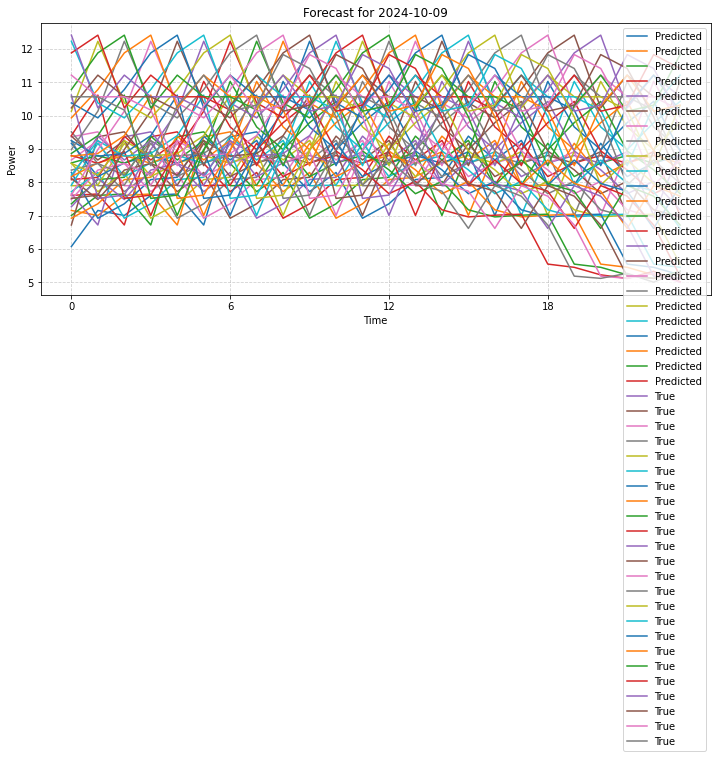

In [449]:
#date = '2018-06-06'
date = plotting.random_date(start_date=str(index_test[0].date()),
                            end_date=str(df.index[-1].date()))

plotting.plot_forecast(pred=df_pred,
                       true=df_true,
                       date=date,
                       horizon=horizon,
                       t_0=t_0,
                       figsize=(12,5),
                       print_metric=True,
                       grid=True)

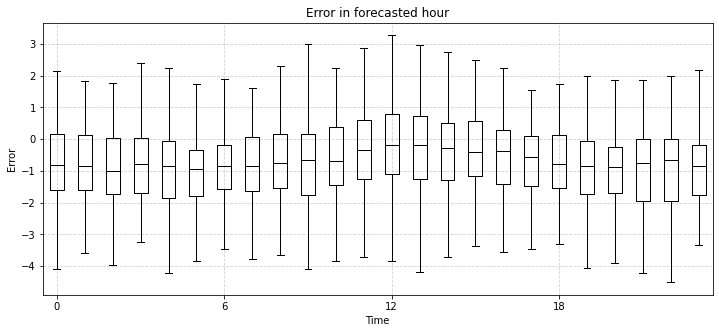

In [450]:
plotting.plot_boxplots(pred=df_pred,
                       true=df_true,
                       t_0=t_0,
                       horizon=horizon,
                       figsize=(12,5),
                       showfliers=False,
                       grid=True)

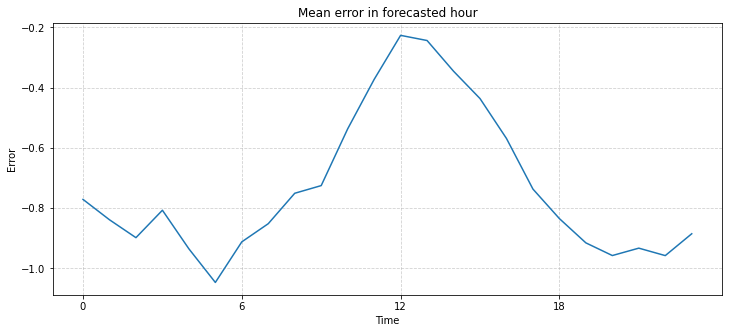

In [451]:
plotting.plot_error(pred=df_pred,
                    true=df_true,
                    t_0=t_0,
                    horizon=horizon,
                    figsize=(12,5),
                    grid=True)

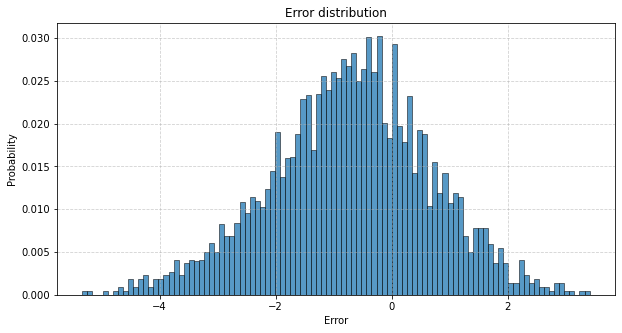

In [452]:
plotting.plot_error_distribution(pred=df_pred,
                                 true=df_true,
                                 figsize=(10,5),
                                 bins=100,
                                 t_0=t_0,
                                 grid=True)